<a href="https://colab.research.google.com/github/chinaskinho/analise_politica_fiscal_monetaria/blob/main/analise_variaveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-bcb

In [ ]:
from bcb import sgs
import pandas as pd

In [ ]:
# @title Baixando dados
res_primario = sgs.get({'Resultado primário': 5354}, start='1998-01-01', end='2024-12-31')
# convertendo para decimais
res_primario['Resultado primário'] = res_primario['Resultado primário'] / 100
res_primario.head()

,Resultado primário
Date,
1998-01-01,-0.0031
1998-02-01,-0.0009
1998-03-01,-0.0419
1998-04-01,-0.0135
1998-05-01,0.0025


In [ ]:
#montar drive
from google.colab import drive
drive.mount('/content/drive')
selic = pd.read_csv('/content/drive/MyDrive/mono/selic diario.csv', sep= ';')
selic.rename(columns={'11 - Interest rate - Selic - % p.d.':'selic'}, inplace=True)
selic.head()

Mounted at /content/drive


,Date,selic
0,02/01/1998,0.121390
1,05/01/1998,0.126422
2,06/01/1998,0.127720
3,07/01/1998,0.128094
4,08/01/1998,0.128008


In [ ]:
# @title Tratando dados selic

#transformando selic para numerico
selic['selic'] = pd.to_numeric(selic['selic'], errors='coerce')
selic['Date'] = pd.to_datetime(selic['Date'], format='%d/%m/%Y', errors='coerce')

# convertendo para mensal por media
selic= selic.resample('M', on='Date').mean()['selic'].to_frame()

selic.head()

/tmp/ipython-input-34-2556668969.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  selic= selic.resample('M', on='Date').mean()['selic'].to_frame()


,selic
Date,
1998-01-31,0.125553
1998-02-28,0.117148
1998-03-31,0.098997
1998-04-30,0.089108
1998-05-31,0.080877


In [ ]:
selic.index = selic.index.to_period('M').to_timestamp()
selic.head()

,selic
Date,
1998-01-01,0.125553
1998-02-01,0.117148
1998-03-01,0.098997
1998-04-01,0.089108
1998-05-01,0.080877


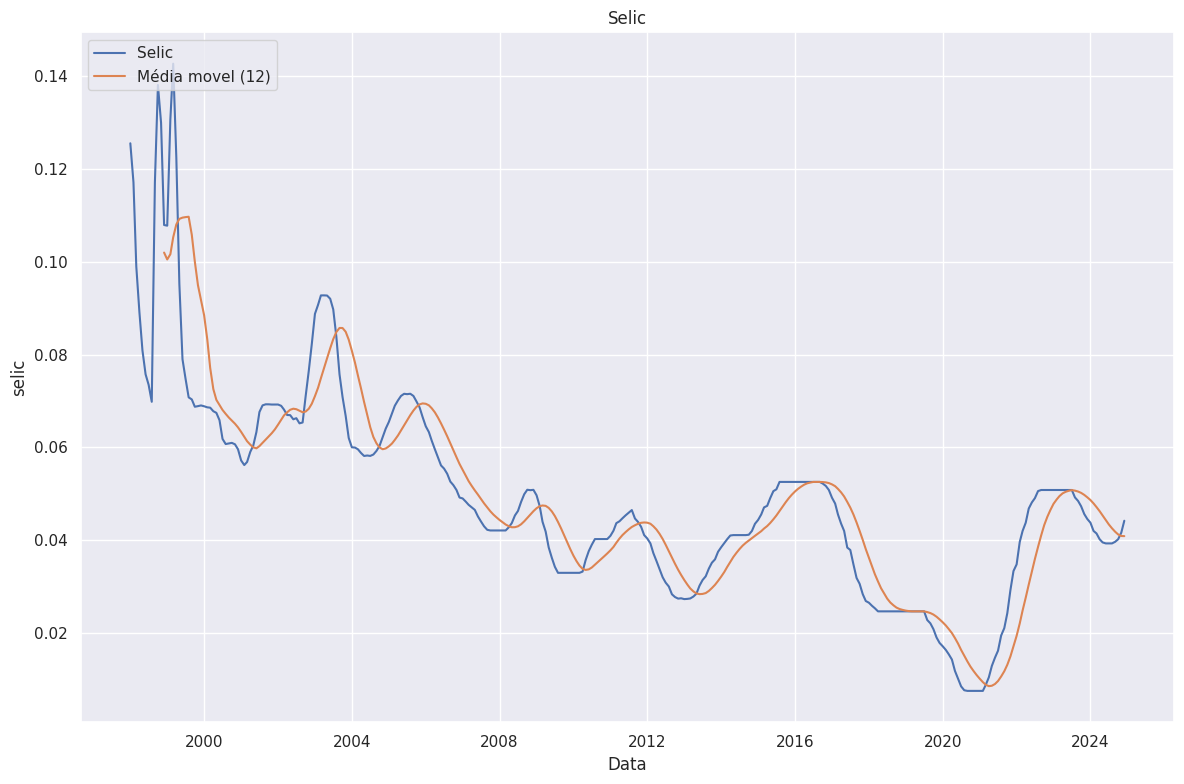

In [ ]:
# @title Gráfico selic
# grafico selic
import matplotlib.pyplot as plt
import seaborn as sns
selic['selic_mv'] = selic['selic'].rolling(window=12).mean()
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=selic, x=selic.index, y='selic', ax=ax, label= 'Selic')
sns.lineplot(data=selic, x=selic.index, y='selic_mv', ax=ax, label = 'Média movel (12)')
ax.set_title('Selic')
ax.set_xlabel('Data')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Aparente tendência de queda. Realizarei o teste ADF Com constante e tendência linear

In [ ]:
# @title teste adf - SELIC
from statsmodels.tsa.stattools import adfuller
# Certificar-se de que a coluna 'selic' é numérica antes de diferenciar
selic['selic'] = pd.to_numeric(selic['selic'], errors='coerce')
selic_diff = selic['selic'].diff().dropna()
#teste adf sem tendecia e sem constante
resultado = adfuller(selic_diff_df['selic'], regression= 'n', autolag='AIC' )
print('Estatística ADF:', resultado[0])
print('p-valor:', resultado[1])
print(f'Lags usados: {resultado[2]}')

NameError: name 'selic_diff_df' is not defined

In [ ]:
#!pip install arch
from arch.unitroot import PhillipsPerron

# Aplicar o teste PP à série Selic
pp_test = PhillipsPerron(selic_diff_df['selic'], trend='n')

# Exibir os resultados
print("=== Teste de Phillip-Perron ===")
print(f"Estatística PP: {pp_test.stat:.4f}")
print(f"p-valor: {pp_test.pvalue:.6f}")
print(f"Número de lags: {pp_test.lags}")
print(f"Críticos: {pp_test.critical_values}")


In [ ]:
# @title Teste KPSS - SELIC
from statsmodels.tsa.stattools import kpss

# Aplicar o teste KPSS à série Selic com tendência ('ct')
# O teste KPSS deve ser aplicado à série diferenciada para verificar estacionariedade após a diferenciação.
kpss_result = kpss(selic_diff, regression='c')


print("=== Teste de KPSS ===")
print(f"Estatística KPSS: {kpss_result[0]:.4f}")
print(f"p-valor: {kpss_result[1]:.6f}")
print(f"Lags usados: {kpss_result[2]}")
print(f"Críticos: {kpss_result[3]}")

if kpss_result[1] > 0.05:
    print("✓ Não rejeita H0: A série é estacionária em torno de uma tendência determinística.")
else:
    print("✗ Rejeita H0: A série não é estacionária em torno de uma tendência determinística.")

A série Selic é estacionaria na segunda diferença


In [ ]:
# grafico selic diff
import matplotlib.pyplot as plt
import seaborn as sns

# Converter selic_diff para DataFrame
selic_diff_df = selic_diff.to_frame()

# Calcular a média móvel na série diferenciada
selic_diff_df['selic_mv'] = selic_diff_df['selic'].rolling(window=12).mean()

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=selic_diff_df, x=selic_diff_df.index, y='selic', ax=ax, label= 'Selic Diferenciada')
sns.lineplot(data=selic_diff_df, x=selic_diff_df.index, y='selic_mv', ax=ax, label = 'Média movel (12) Diferenciada')
ax.set_title('Selic Diferenciada')
ax.set_xlabel('Data')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# @title Teste de Autocorrelação (Ljung-Box) - Selic Diferenciada
from statsmodels.stats.diagnostic import acorr_ljungbox

print("=== TESTE DE AUTOCORRELAÇÃO DOS RESÍDUOS (Ljung-Box) - Selic Diferenciada ===\n")

# Teste Ljung-Box com diferentes lags para a série diferenciada
# O número de lags a testar pode depender do tamanho da série. Vamos testar com alguns lags comuns.
for lag in [12, 24, 36]:
    if lag < len(selic_diff):
        ljung_box_diff = acorr_ljungbox(selic_diff, lags=lag, return_df=True)
        p_value_diff = ljung_box_diff['lb_pvalue'].iloc[-1]

        print(f"Lag {lag}: p-value = {p_value_diff:.4f}", end="")
        if p_value_diff > 0.05:
            print(" ✓ (Não rejeita H0 - sem autocorrelação)")
        else:
            print(" ✗ (Rejeita H0 - há autocorrelação)")
    else:
        print(f"Série muito curta para testar lag {lag}")

In [ ]:
# @title Gráficos Resultado Primário
import matplotlib.pyplot as plt
import seaborn as sns
# media movel
res_primario['Resultado primário_MV'] = res_primario['Resultado primário'].rolling(window=12).mean()

#plotar grafico com intercepto
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 8))
#intercepto no grafico
intercept_value = 0
ax.axhline(y=intercept_value, color='red', linestyle='--')

sns.lineplot(data=res_primario, x=res_primario.index, y='Resultado primário', ax=ax, label= 'Resultado primário')
sns.lineplot(data=res_primario, x=res_primario.index, y='Resultado primário_MV', ax=ax, label = 'Média movel (12)')
ax.set_title('Resultado Primário/ PIB')
ax.set_xlabel('Data')
ax.set_ylabel('Valor')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

A média movel mostra uma tendencia indefinida. o teste adf será feita com regressão com constante e sem tendência.

In [ ]:
# @title teste ADF sem intercepto
resultado = adfuller(res_primario['Resultado primário'], regression= 'n', autolag='AIC' )
print('Estatística ADF:', resultado[0])
print('p-valor:', resultado[1])
print(f'Lags usados: {resultado[2]}')

Resultado Primário é estacionário em nível em regressão sem constante.

In [ ]:
# @title juntando dataframe
# Drop the 'selic_diff' column instead of 'selic'
res_primario = res_primario.drop('Resultado primário_MV', axis=1)
selic = selic.drop('selic_mv', axis=1)
# Ensure 'selic_diff' is dropped from selic before concatenation
selic = selic.drop('selic_diff', axis=1, errors='ignore') # Use errors='ignore' in case selic_diff is already dropped
dados_mono = pd.concat([res_primario, selic], axis=1).dropna() # Drop any rows with NaNs that might result from concatenation

dados_mono.head()

In [ ]:
#salvando arquivo
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
#dados_mono.to_csv('/content/drive/MyDrive/mono/dados_mono.csv')
#carregando arquivo
dados_mono = pd.read_csv('/content/drive/MyDrive/mono/dados_mono.csv', index_col=0, parse_dates=True)
# Set the first value of 'selic_diff' column manually
# Replace 'your_manual_value' with the value you want to set
dados_mono.loc[dados_mono.index[0], 'selic_diff'] = -0.008405
dados_mono.head()

Mounted at /content/drive


,Resultado primário,selic,selic_diff
Date,,,
1998-01-01,-0.0031,0.125553,-0.008405
1998-02-01,-0.0009,0.117148,-0.008405
1998-03-01,-0.0419,0.098997,-0.018151
1998-04-01,-0.0135,0.089108,-0.009889
1998-05-01,0.0025,0.080877,-0.008231


In [ ]:
# apagar coluna selic
dados_mono = dados_mono.drop('selic', axis=1)

In [ ]:
# @title Teste de normalidade (Jarque-Bera)
print("=== TESTE DE NORMALIDADE DOS RESÍDUOS (Jarque-Bera) ===\n")

normalidade_resultado = modelo_ajustado.test_normality()

print(f"Estatística JB: {normalidade_resultado.test_statistic:.4f}")
print(f"p-value: {normalidade_resultado.pvalue:.6f}")

if normalidade_resultado.pvalue > 0.05:
    print("✓ Não rejeita H0: Resíduos seguem distribuição normal")
else:
    print("✗ Rejeita H0: Resíduos NÃO seguem distribuição normal")

# Teste individual por série (Shapiro-Wilk)
from scipy.stats import shapiro

print("\n=== TESTE SHAPIRO-WILK (INDIVIDUAL) ===")
for coluna in residuos.columns:
    if len(residuos[coluna]) <= 5000:  # Shapiro-Wilk tem limitação de tamanho
        stat, p_value = shapiro(residuos[coluna])
        print(f"{coluna}: p-value = {p_value:.6f}", end="")
        if p_value > 0.05:
            print(" ✓ (Normal)")
        else:
            print(" ✗ (Não normal)")
    else:
        print(f"{coluna}: Amostra muito grande para Shapiro-Wilk")

=== TESTE DE NORMALIDADE DOS RESÍDUOS (Jarque-Bera) ===

Estatística JB: 158192.2714
p-value: 0.000000
✗ Rejeita H0: Resíduos NÃO seguem distribuição normal

=== TESTE SHAPIRO-WILK (INDIVIDUAL) ===
Resultado primário: p-value = 0.000000 ✗ (Não normal)
selic_diff: p-value = 0.000000 ✗ (Não normal)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


=== FUNÇÃO DE RESPOSTA AO IMPULSO (IRF) ===
Analisando o impacto de um choque na Selic sobre as variáveis do modelo.


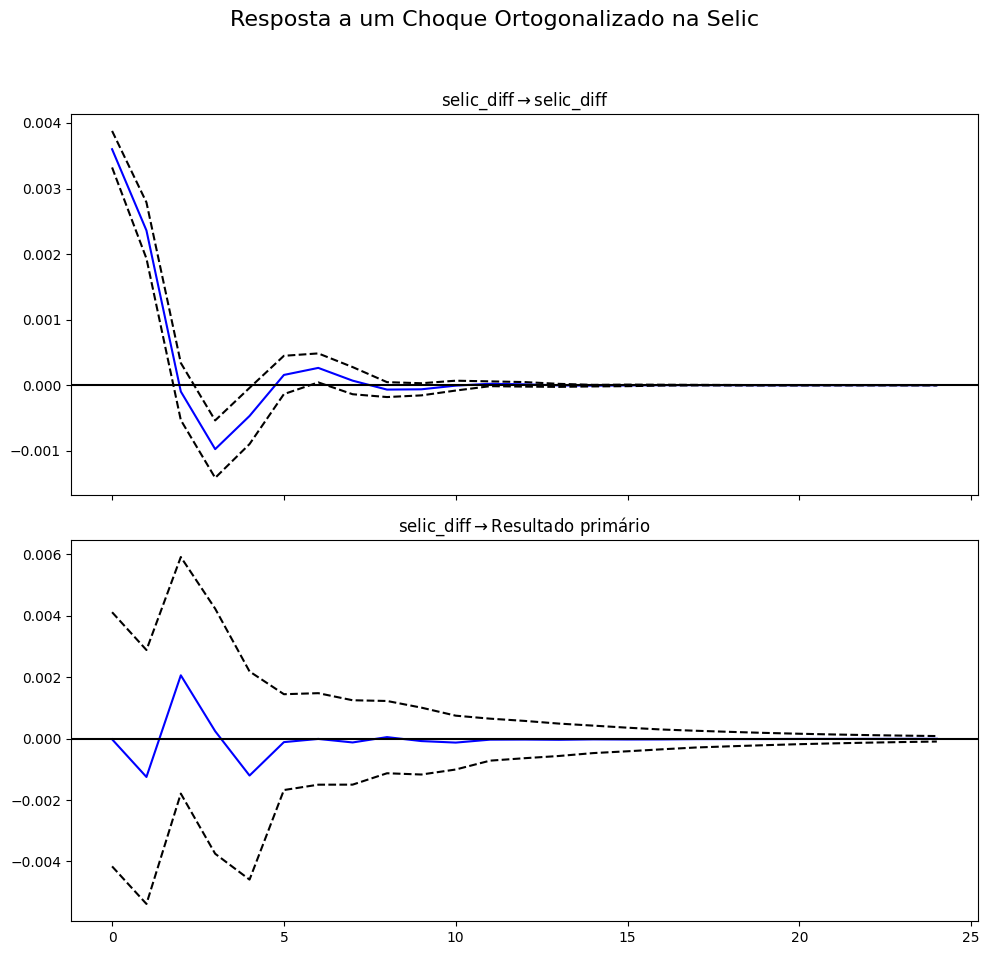

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt


# 1. Reordenar as colunas para aplicar a restrição de Cholesky
# A Selic se torna a primeira variável, tornando-a contemporaneamente exógena.
dados_reordenados = dados_mono[['selic_diff', 'Resultado primário']]

# 2. Estimar o modelo VAR com os dados reordenados e o lag escolhido
modelo_var_reordenado = VAR(dados_reordenados)
modelo_ajustado_reordenado = modelo_var_reordenado.fit(lag_escolhido)

# 3. Gerar a Função de Resposta ao Impulso (IRF)
irf = modelo_ajustado_reordenado.irf(periods=24)

# 4. Plotar a resposta de todas as variáveis a um choque na Selic
# A ordem das variáveis para o plot é [selic, Resultado primário]
print("=== FUNÇÃO DE RESPOSTA AO IMPULSO (IRF) ===")
print("Analisando o impacto de um choque na Selic sobre as variáveis do modelo.")
plot = irf.plot(orth=True, impulse='selic_diff', response=None, signif=0.05)
plot.suptitle('Resposta a um Choque Ortogonalizado na Selic', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para o título não sobrepor os gráficos
plt.show()

=== FUNÇÃO DE RESPOSTA AO IMPULSO (IRF) ===
Analisando o impacto de um choque no Resultado Primário sobre as variáveis do modelo.


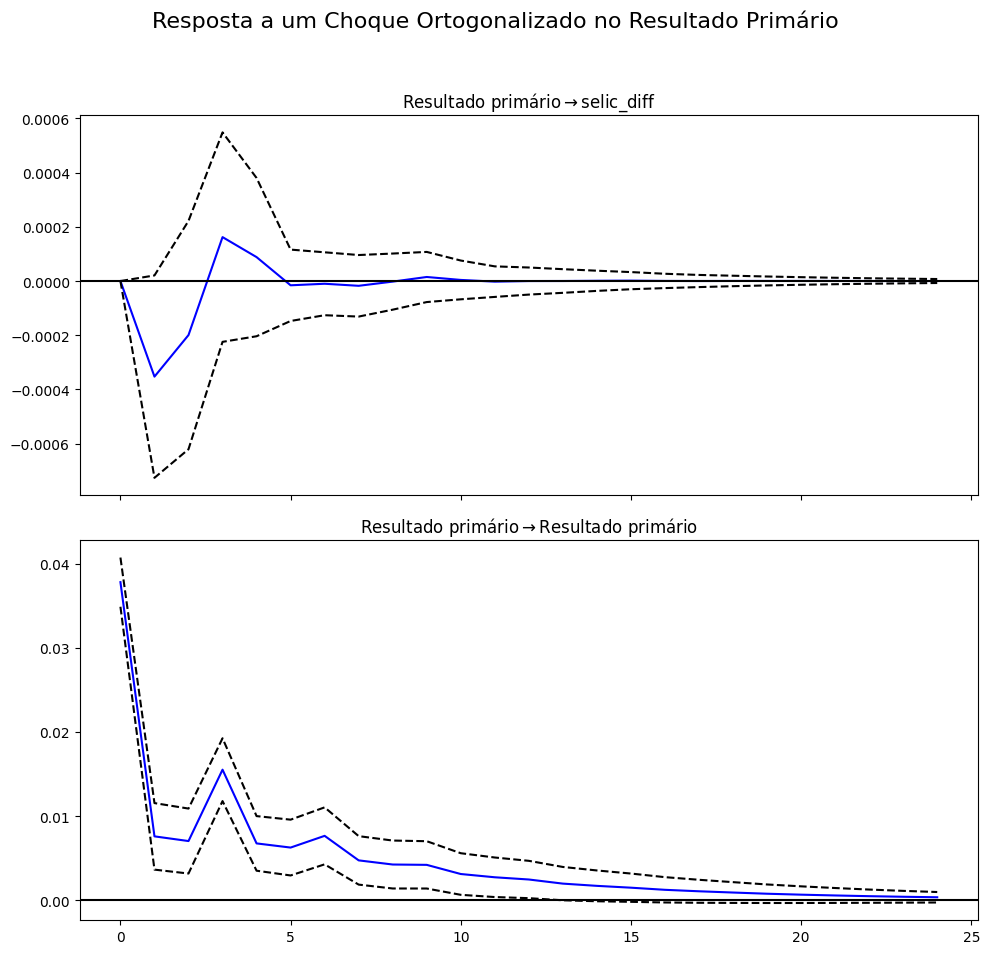

In [ ]:

# 4. (Repetindo a partir do passo anterior) Gerar a Função de Resposta ao Impulso (IRF)
# O objeto 'irf' já foi calculado e contém as respostas para todos os choques.
irf = modelo_ajustado_reordenado.irf(periods=24)

# 5. Plotar a resposta de todas as variáveis a um choque no Resultado Primário
# Trocamos o 'impulse' de 'selic' para 'Resultado primário'
print("=== FUNÇÃO DE RESPOSTA AO IMPULSO (IRF) ===")
print("Analisando o impacto de um choque no Resultado Primário sobre as variáveis do modelo.")
plot_rp = irf.plot(orth=True, impulse='Resultado primário', response=None, signif=0.05)
plot_rp.suptitle('Resposta a um Choque Ortogonalizado no Resultado Primário', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para o título não sobrepor os gráficos
plt.show()

In [ ]:
# @title Matriz de Variância-Covariância dos Resíduos
# Extrair a matriz de covariância dos resíduos
matriz_covariancia = modelo_ajustado_reordenado.sigma_u

print("=== MATRIZ DE VARIÂNCIA-COVARIÂNCIA DOS RESÍDUOS ===")
# Exibir a matriz como um DataFrame para melhor visualização
matriz_cov_df = pd.DataFrame(matriz_covariancia, index=dados_reordenados.columns, columns=dados_reordenados.columns)
display(matriz_cov_df)

=== MATRIZ DE VARIÂNCIA-COVARIÂNCIA DOS RESÍDUOS ===


,selic_diff,Resultado primário
selic_diff,1.295818e-05,-7.964979e-08
Resultado primário,-7.964979e-08,1.430266e-03


In [ ]:
# analisar se os parametros são siginificativos, verificar se é ruido branco -teste lm- , teste ortogonal , lung box nos residuos do modelo, teste de hetericidadfe condiconal -teste white-, estabilidadfe do modelo, no zap

In [ ]:
# @title Teste de Autocorrelação dos Resíduos (LM test - White Noise)
from statsmodels.stats.api import het_arch
from statsmodels.stats.stattools import durbin_watson

print("=== TESTE LM PARA AUTOCORRELAÇÃO DOS RESÍDUOS ===\n")

# Perform the LM test for each residual series
for col in residuos.columns:
    print(f"--- {col} ---")
    # The number of lags for the LM test can be chosen based on the VAR order or other criteria.
    # Let's use the same lag as the VAR model for consistency, or a slightly higher value.
    # Using the VAR lag order: modelo_ajustado.k_ar
    lm_test_result = modelo_ajustado.test_whiteness(nlags=modelo_ajustado.k_ar, adjusted=True)
    print(f"LM Statistic: {lm_test_result.statistic:.4f}")
    print(f"p-value: {lm_test_result.pvalue:.4f}")

    if lm_test_result.pvalue > 0.05:
        print("✓ Não rejeita H0: Resíduos são ruído branco (sem autocorrelação)")
    else:
        print("✗ Rejeita H0: Resíduos NÃO são ruído branco (há autocorrelação)")
    print()

# Durbin-Watson test (can also indicate autocorrelation)
print("\n=== TESTE DE DURBIN-WATSON ===")
dw = durbin_watson(residuos)
for i, col in enumerate(residuos.columns):
    print(f"{col}: {dw[i]:.4f}")
    if dw[i] > 1.5 and dw[i] < 2.5:
        print("✓ Sugere pouca ou nenhuma autocorrelação")
    else:
        print("✗ Sugere autocorrelação")

=== TESTE LM PARA AUTOCORRELAÇÃO DOS RESÍDUOS ===

--- Resultado primário ---


ValueError: The whiteness test can only be used when nlags is larger than the number of lags included in the model (3).

In [ ]:
# @title Teste de Ortogonalidade dos Resíduos (Teste de Correlação Cruzada)
print("=== TESTE DE ORTOGONALIDADE DOS RESÍDUOS ===\n")

# Calculate the correlation matrix of the residuals
correlation_matrix = residuos.corr()

print("Matriz de Correlação dos Resíduos:")
display(correlation_matrix)

=== TESTE DE ORTOGONALIDADE DOS RESÍDUOS ===

Matriz de Correlação dos Resíduos:


,Resultado primário,selic_diff
Resultado primário,1.000000,-0.000585
selic_diff,-0.000585,1.000000


In [ ]:
# @title Teste de Estabilidade do Modelo (Verificação dos Autovalores)
import numpy as np
import matplotlib.pyplot as plt

print("=== TESTE DE ESTABILIDADE DO MODELO VAR ===\n")


inverse_roots = modelo_ajustado.roots

#Os autovalores são os recíprocos das raízes inversas.
eigenvalues = 1. / inverse_roots

print("Autovalores da Matriz Companheira:")
print(eigenvalues)

# Verifica se todos os autovalores têm módulo menor que 1.
moduli = np.abs(eigenvalues)
max_modulus = np.max(moduli)

print(f"\nMódulo máximo dos autovalores: {max_modulus:.4f}")

if max_modulus < 1:
    print("\n✓ O módulo máximo dos autovalores é menor que 1.")
    print("O modelo VAR é estacionário (estável).")
else:
    print("\n✗ O módulo máximo dos autovalores é maior ou igual a 1.")
    print("O modelo VAR NÃO é estacionário (instável).")

=== TESTE DE ESTABILIDADE DO MODELO VAR ===

Autovalores da Matriz Companheira:
[ 0.15812024+0.j          0.25513131-0.57550693j  0.25513131+0.57550693j
 -0.33182683-0.54603181j -0.33182683+0.54603181j  0.85150458+0.j        ]

Módulo máximo dos autovalores: 0.8515

✓ O módulo máximo dos autovalores é menor que 1.
O modelo VAR é estacionário (estável).


In [ ]:
# @title Teste de Ortogonalidade dos Resíduos (Teste de Correlação Cruzada)
print("=== TESTE DE ORTOGONALIDADE DOS RESÍDUOS ===\n")


correlation_matrix = residuos.corr()

print("Matriz de Correlação dos Resíduos:")
display(correlation_matrix)

=== TESTE DE ORTOGONALIDADE DOS RESÍDUOS ===

Matriz de Correlação dos Resíduos:


,Resultado primário,selic_diff
Resultado primário,1.000000,-0.000585
selic_diff,-0.000585,1.000000


In [ ]:
# @title Teste de Heteroskedasticidade Condicional (Teste de White)
from statsmodels.stats.diagnostic import het_white

print("=== TESTE DE WHITE PARA HETEROSKEDASTICIDADE CONDICIONAL ===\n")

print("--- Teste de ARCH nos Resíduos (Indicador de Heteroskedasticidade Condicional) ---")
# Test for ARCH effects up to a certain lag (e.g., lag 12 or based on VAR order)
arch_lags = 12 # lag diferente

for col in residuos.columns:
    print(f"\n--- {col} ---")
    # het_arch returns (lm_statistic, p_value, f_statistic, f_p_value)
    arch_test_result = het_arch(residuos[col], nlags=arch_lags)
    print(f"LM Statistic: {arch_test_result[0]:.4f}")
    print(f"p-value: {arch_test_result[1]:.4f}")

    if arch_test_result[1] > 0.05:
        print("✓ Não rejeita H0: Sem efeitos ARCH (homoskedasticidade condicional)")
    else:
        print("✗ Rejeita H0: Há efeitos ARCH (heteroskedasticidade condicional)")

=== TESTE DE WHITE PARA HETEROSKEDASTICIDADE CONDICIONAL ===

--- Teste de ARCH nos Resíduos (Indicador de Heteroskedasticidade Condicional) ---

--- Resultado primário ---
LM Statistic: 80.5533
p-value: 0.0000
✗ Rejeita H0: Há efeitos ARCH (heteroskedasticidade condicional)

--- selic_diff ---
LM Statistic: 296.9837
p-value: 0.0000
✗ Rejeita H0: Há efeitos ARCH (heteroskedasticidade condicional)


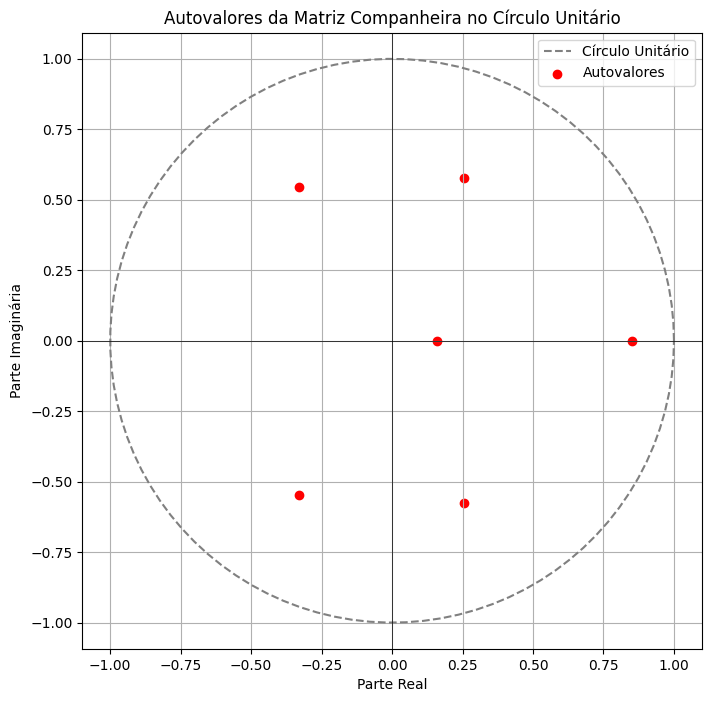

In [ ]:
# @title Gráfico do Círculo Unitário com Autovalores

plt.figure(figsize=(8, 8))
# Plotar o círculo unitário
theta = np.linspace(0, 2 * np.pi, 100)
a = np.cos(theta)
b = np.sin(theta)
plt.plot(a, b, linestyle='--', color='gray', label='Círculo Unitário')

# Plotar os autovalores
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), color='red', label='Autovalores')

plt.title('Autovalores da Matriz Companheira no Círculo Unitário')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)
plt.axis('equal') # Garante que o círculo não seja distorcido
plt.legend()
plt.show()